# Iris Pytorch

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#### Загрузка данных

In [2]:
iris = datasets.load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


### Exploratory Data Analysis (EDA)

In [3]:
df['target'].value_counts()

target
0    50
1    50
2    50
Name: count, dtype: int64

In [4]:
df.isna().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64

In [5]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


#### График распределения признаков

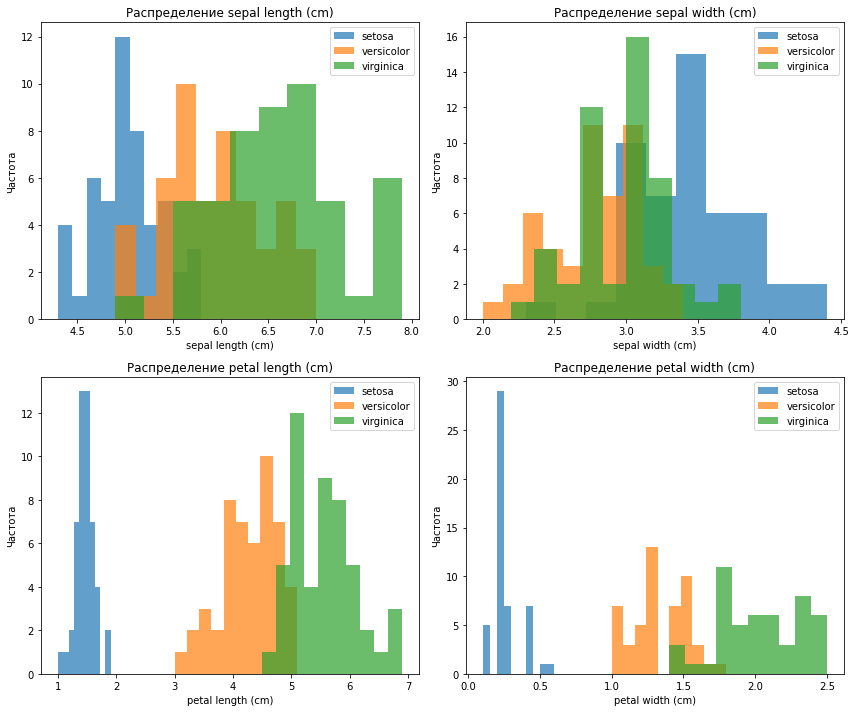

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
features = iris.feature_names

for i, feature in enumerate(features):
    ax = axes[i//2, i%2]
    for target in range(3):
        ax.hist(df[df['target'] == target][feature], 
               alpha=0.7, label=iris.target_names[target])
    ax.set_title(f'Распределение {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Частота')
    ax.legend()

plt.tight_layout()
plt.show()

#### Матрица корреляций

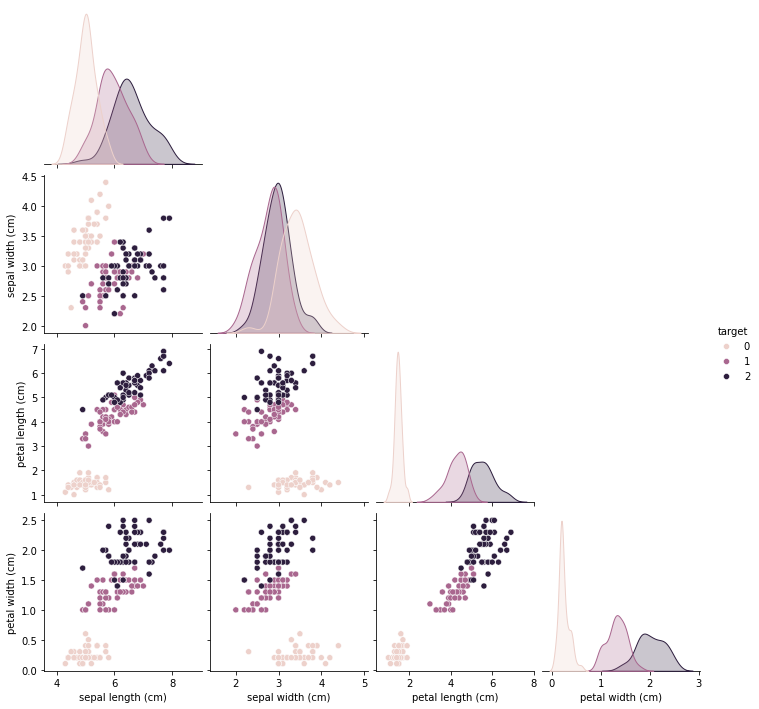

In [7]:
sns.pairplot(df, hue='target', corner=True)
plt.show()

### Подготовка данных

#### Разделение данных

In [8]:
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)

(120, 4) (30, 4)


#### Масштабирование данных

In [9]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### DataLoaders

In [10]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

train_loader = DataLoader(
    TensorDataset(X_train, y_train), 
    batch_size=8, 
    shuffle=True, 
    num_workers=2, 
    persistent_workers=True
)
test_loader = DataLoader(
    TensorDataset(X_test, y_test), 
    batch_size=8, 
    shuffle=False, 
    num_workers=2, 
    persistent_workers=True
)

### Архитектура модели

In [11]:
class IrisModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=32, output_size=3):
        super(IrisModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = IrisModel()
print(model)

IrisModel(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


### Обучение модели

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_accuracies = []

epochs = 100
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    batch_count = 0
    
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        batch_count += 1
    
    avg_train_loss = total_train_loss / batch_count
    train_losses.append(avg_train_loss)
    
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            predicted = torch.argmax(outputs, dim=1)
            total_correct += (predicted == y_batch).sum().item()
            total_samples += y_batch.size(0)
    
    accuracy = total_correct / total_samples
    test_accuracies.append(accuracy)
    
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch:3d}: "
              f"Train Loss = {avg_train_loss:.4f}, "
              f"Test Accuracy = {accuracy:.4f}")

print(f"\nФинальная точность: {test_accuracies[-1]:.4f}")

Epoch   0: Train Loss = 1.0920, Test Accuracy = 0.5667
Epoch  10: Train Loss = 0.3456, Test Accuracy = 0.8000
Epoch  20: Train Loss = 0.1833, Test Accuracy = 0.9000
Epoch  30: Train Loss = 0.1134, Test Accuracy = 0.9667
Epoch  40: Train Loss = 0.0801, Test Accuracy = 0.9333
Epoch  50: Train Loss = 0.0988, Test Accuracy = 0.9667
Epoch  60: Train Loss = 0.0619, Test Accuracy = 0.9667
Epoch  70: Train Loss = 0.0775, Test Accuracy = 0.9667
Epoch  80: Train Loss = 0.0493, Test Accuracy = 0.9667
Epoch  90: Train Loss = 0.0522, Test Accuracy = 0.9667
Epoch  99: Train Loss = 0.0647, Test Accuracy = 0.9667

Финальная точность: 0.9667


### Визуализация результатов

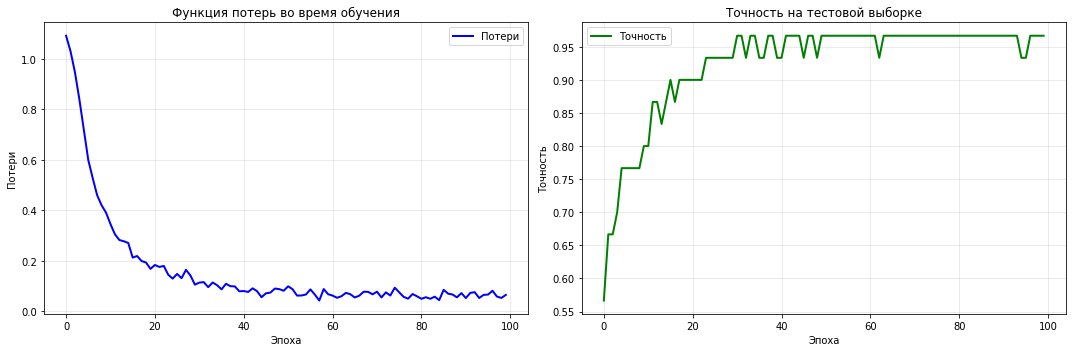

In [13]:
ig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# График функции потерь
ax1.plot(train_losses, 'b-', linewidth=2, label='Потери')
ax1.set_title('Функция потерь во время обучения')
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Потери')
ax1.grid(True, alpha=0.3)
ax1.legend()

# График точности
ax2.plot(test_accuracies, 'g-', linewidth=2, label='Точность')
ax2.set_title('Точность на тестовой выборке')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Точность')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()